## First look at CNTDIFF_7Tr parabolic profiles

In [37]:
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import xarray as xr
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

In [16]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [71]:
# Grid, state and tracers datasets of base case
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_7Tr/run01/gridGlob.nc'
grid = xr.open_dataset(grid_file)

state_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_7Tr/run01/stateGlob.nc' 
state = xr.open_dataset(state_file)

ptracers_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF_7Tr/run01/ptracersGlob.nc'
ptracers = xr.open_dataset(ptracers_file)


### Initial profiles

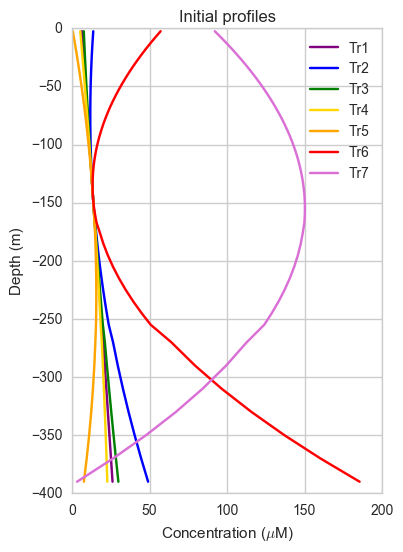

In [31]:
# plot_ini_profiles
tracerList = [ptracers.Tr1,ptracers.Tr2,ptracers.Tr3,ptracers.Tr4,ptracers.Tr5,ptracers.Tr6,ptracers.Tr7]
labels = ['Tr1','Tr2','Tr3','Tr4','Tr5','Tr6','Tr7']

colours = ['purple','blue','green','gold','orange','red','orchid',]

fig,ax = plt.subplots(1,1,figsize=(4,6))
for tracer,col,lab in zip(tracerList,colours,labels):
    ax.plot(tracer.isel(T=0,X=180,Y=50,Z=slice(0,50)),grid.Z[0:50],color=col,label=lab)

ax.set_xlabel(r'Concentration ($\mu$M)')
ax.set_ylabel('Depth (m)')
ax.set_title('Initial profiles')
ax.legend(loc=0)

### BAC

In [86]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

def ConcAreaFunc(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((19,360,360))
    Conc = np.empty((19,360,360))
    ConcFiltered = np.empty((19,360,360))
    Area = np.empty((19,360,360))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    print(np.shape(BottomInd))
    for tt in range(19):
        #print(tt)
        for j in range(360):
            for i in range(360):
                TrBottom = Tr[tt,BottomInd[i,j],i,j]
                if TrBottom > 0.0:
                    ConcArea[tt,i,j] = TrBottom*ra[i,j]
                    Conc[tt,i,j] = TrBottom
                    Area[tt,i,j] = ra[i,j]
                else:
                    ConcArea[tt,i,j] = np.NaN
                    Conc[tt,i,j] = np.NaN
                    Area[tt,i,j] = np.NaN
                    
            # Filter step noise
            ConcFiltered[tt,:,j] = sg.savitzky_golay(Conc[tt,:,j], 7,3) 
                
    print(np.shape(ConcArea))
    
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def PlotBAC(ax,ConcFilt,tslice,xslice,yslice,cmap=cmo.cm.tempo):
    
    BAC = ConcFilt[tslice,yslice,xslice]
    
    maxCM = np.max(BAC)
    minCM = np.min(BAC)
    
    mesh = ax.contourf(grid.X[xslice]/1000,grid.Y[yslice]/1000,BAC,21, 
                      vmax=maxCM, 
                      vmin=minCM,
                      cmap=cmap)
    
    #cbar_ax = fig.add_axes([0.9, 0.327, 0.015, 0.252])
    #cb=fig.colorbar(mesh, cax=cbar_ax,ticks=[5.2,6.2,7.2,8.2,9.2,10.2],format='%.1f')
    #cb.ax.yaxis.set_tick_params(pad=1)
    fig.colorbar(mesh,ax=ax)
    ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    
    SB = ax.contour(grid.X[xslice]/1000,grid.Y[yslice]/1000,
                     grid.Depth[yslice,xslice],
                    [150.0],
                    colors='0.1',linewidths=[0.75] )
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)


In [83]:
ConcArea1, ConcFilt1, Area1 = ConcAreaFunc(ptracers.Tr1.data, grid.HFacC.data, grid.rA.data, grid.Depth.data)
ConcArea2, ConcFilt2, Area2 = ConcAreaFunc(ptracers.Tr2.data, grid.HFacC.data, grid.rA.data, grid.Depth.data)
ConcArea3, ConcFilt3, Area3 = ConcAreaFunc(ptracers.Tr3.data, grid.HFacC.data, grid.rA.data, grid.Depth.data)
ConcArea4, ConcFilt4, Area4 = ConcAreaFunc(ptracers.Tr4.data, grid.HFacC.data, grid.rA.data, grid.Depth.data)
ConcArea5, ConcFilt5, Area5 = ConcAreaFunc(ptracers.Tr5.data, grid.HFacC.data, grid.rA.data, grid.Depth.data)
ConcArea6, ConcFilt6, Area6 = ConcAreaFunc(ptracers.Tr6.data, grid.HFacC.data, grid.rA.data, grid.Depth.data)
ConcArea7, ConcFilt7, Area7 = ConcAreaFunc(ptracers.Tr7.data, grid.HFacC.data, grid.rA.data, grid.Depth.data)

(360, 360)


/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)
(360, 360)
(19, 360, 360)


In [84]:
# General input
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

yslice = slice(225,360)
xslice = slice(0,360)


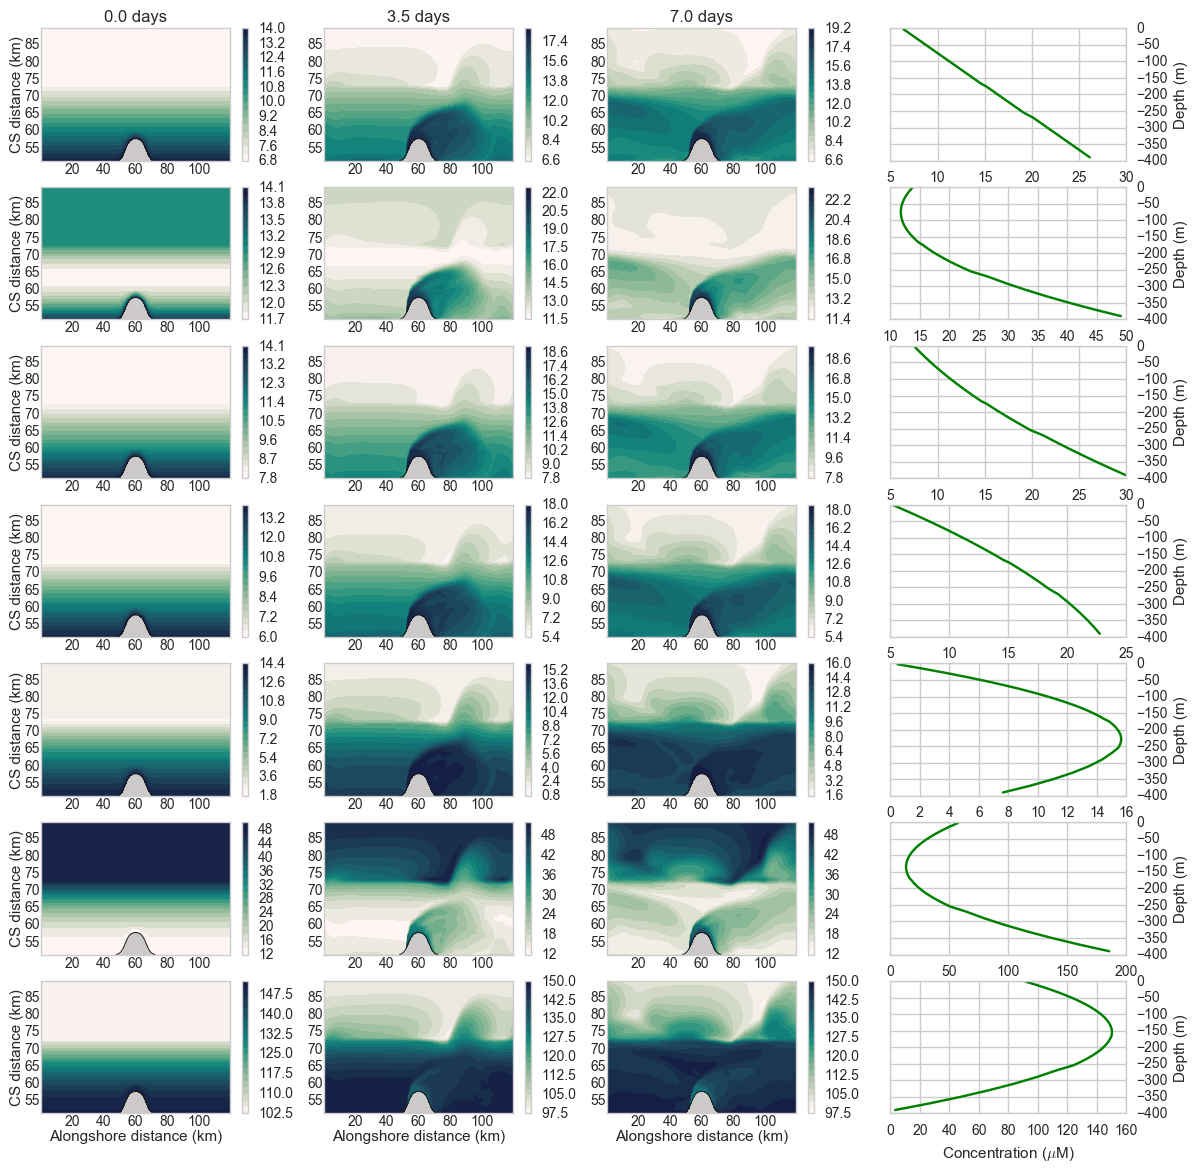

In [85]:
fig, ax = plt.subplots(7,4,figsize=(14,14))


for ii,tt in zip(range(0,3),np.arange(0,20,7)):
    PlotBAC(ax[0,ii],ConcFilt1,tt,xslice,yslice)
    PlotBAC(ax[1,ii],ConcFilt2,tt,xslice,yslice)
    PlotBAC(ax[2,ii],ConcFilt3,tt,xslice,yslice)
    PlotBAC(ax[3,ii],ConcFilt4,tt,xslice,yslice)
    PlotBAC(ax[4,ii],ConcFilt5,tt,xslice,yslice)
    PlotBAC(ax[5,ii],ConcFilt6,tt,xslice,yslice)
    PlotBAC(ax[6,ii],ConcFilt7,tt,xslice,yslice)
    
    ax[0,ii].set_title('%1.1f days' % ((state.iter[tt]*40)/(3600*24)))

tracerList = [ptracers.Tr1,ptracers.Tr2,ptracers.Tr3,ptracers.Tr4,ptracers.Tr5,ptracers.Tr6,ptracers.Tr7]

for ii,trac in zip(range(len(tracerList)),tracerList):
    ax[ii,3].plot(trac.isel(T=0,X=180,Y=50,Z=slice(0,50)),grid.Z[0:50],color='green')
    ax[ii,3].yaxis.tick_right()
    ax[ii,3].yaxis.set_label_position("right")
    ax[ii,3].set_ylabel('Depth (m)')
    
    ax[ii,0].set_ylabel('CS distance (km)',labelpad=0.3)

ax[6,3].set_xlabel(r'Concentration ($\mu$M)')

    
ax[0,2].text(0.6,0.8,'BAC ($\mu$M)',transform=ax[0,3].transAxes)
ax[6,0].set_xlabel('Alongshore distance (km)',labelpad=0.3)
ax[6,1].set_xlabel('Alongshore distance (km)',labelpad=0.3)
ax[6,2].set_xlabel('Alongshore distance (km)',labelpad=0.3)



In [ ]:
fig, ax = plt.subplots(7,4,figsize=(14,14))


for ii,tt in zip(range(0,3),np.arange(0,20,7)):
    PlotBAC(ax[0,ii],ConcFilt1-ConcFilt1[0,:,:],tt,xslice,yslice,cmap=cmo.cm.curl)
    PlotBAC(ax[1,ii],ConcFilt2-ConcFilt2[0,:,:],tt,xslice,yslice,cmap=cmo.cm.curl)
    PlotBAC(ax[2,ii],ConcFilt3-ConcFilt3[0,:,:],tt,xslice,yslice,cmap=cmo.cm.curl)
    PlotBAC(ax[3,ii],ConcFilt4-ConcFilt4[0,:,:],tt,xslice,yslice,cmap=cmo.cm.curl)
    PlotBAC(ax[4,ii],ConcFilt5-ConcFilt5[0,:,:],tt,xslice,yslice,cmap=cmo.cm.curl)
    PlotBAC(ax[5,ii],ConcFilt6-ConcFilt6[0,:,:],tt,xslice,yslice,cmap=cmo.cm.curl)
    PlotBAC(ax[6,ii],ConcFilt7-ConcFilt7[0,:,:],tt,xslice,yslice,cmap=cmo.cm.curl)
    
    ax[0,ii].set_title('%1.1f days' % ((state.iter[tt]*40)/(3600*24)))

tracerList = [ptracers.Tr1,ptracers.Tr2,ptracers.Tr3,ptracers.Tr4,ptracers.Tr5,ptracers.Tr6,ptracers.Tr7]

for ii,trac in zip(range(len(tracerList)),tracerList):
    ax[ii,3].plot(trac.isel(T=0,X=180,Y=50,Z=slice(0,50)),grid.Z[0:50],color='green')
    ax[ii,3].yaxis.tick_right()
    ax[ii,3].yaxis.set_label_position("right")
    ax[ii,3].set_ylabel('Depth (m)')
    
    ax[ii,0].set_ylabel('CS distance (km)',labelpad=0.3)

ax[6,3].set_xlabel(r'Concentration ($\mu$M)')

    
ax[0,2].text(0.6,0.8,'BAC ($\mu$M)',transform=ax[0,3].transAxes)
ax[6,0].set_xlabel('Alongshore distance (km)',labelpad=0.3)
ax[6,1].set_xlabel('Alongshore distance (km)',labelpad=0.3)
ax[6,2].set_xlabel('Alongshore distance (km)',labelpad=0.3)

